# Loader加载器
+ 加载PDF
+ 使用多模态解析图文PDF
+ 加载网页
+ 加载CSV及Excel
+ 自定义一个文件加载器

In [7]:
import os
from dotenv import load_dotenv

# 加载 .env 文件中的环境变量
load_dotenv(override=True)  # 使用 override=True 确保加载最新的 .env 数据

True

In [1]:
! pip install langchain_community

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


## 加载PDF

In [2]:
! pip install pypdf

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [3]:
from langchain_community.document_loaders import PyPDFLoader

file_path = "../../sources/fake.pdf"
loader = PyPDFLoader(file_path)

pages = []
# 加载每页
async for page in loader.alazy_load():
    pages.append(page)

Ignoring wrong pointing object 6 0 (offset 0)


In [4]:
print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'producer': 'macOS 版本14.1.1（版号23B81） Quartz PDFContext', 'creator': 'PyPDF', 'creationdate': "D:20231205083748Z00'00'", 'moddate': "D:20231205083748Z00'00'", 'source': '../../sources/fake.pdf', 'total_pages': 3, 'page': 0, 'page_label': '1'}

一、公司基本信息 名称：宏图科技发展有限公司 注册地址：江苏省南京市雨花台区软件大道101号 成立日期：2011年5月16日 法定代表人：李强 注册资本：人民币5000万元 员工人数：约200人 联系电话：025-88888888 电子邮箱：info@hongtutech.cn  二、财务状况概述 截至2023年第一季度，宏图科技发展有限公司财务状况堪忧，具体情况如下： 1. 资产总额：人民币1.2亿元，较上年同期下降30%。 2. 负债总额：人民币1.8亿元，较上年同期上升50%，资不抵债。 3. 营业收入：人民币3000万元，较上年同期下降60%。 4. 净利润：亏损人民币800万元，去年同期为盈利人民币200万元。 5. 现金流量：公司现金流量紧张，现金及现金等价物余额为人民币500万元，难以支撑日常运营。 6. 存货： 存货积压严重， 库存商品价值约为人民币400万元， 大部分产品滞销。 7. 应收账款：应收账款高达人民币600万元，回收难度大，坏账准备不足。  三、主营业务及市场状况 宏图科技发展有限公司主要从事计算机软件的研发与销售。近年来，由于市场竞争加剧、技术更新换代速度快和管理层决策失误等原因，公司主营业务收入持续下降。目前，公司面临的主要问题有： 1. 产品同质化严重，缺乏核心竞争力。 2. 新产品开发进度缓慢，未能及时抓住市场需求变化。 3. 市场营销策略不当，导致市场份额大幅缩水。


## 多模态模型解析PDF
对于包含图片内容的PDF可以使用多模态或unstructured解析

In [9]:
! pip install -qU PyMuPDF pillow langchain-openai IPython

In [10]:
import base64
import io

import fitz
from PIL import Image


# 将PDF图片转为Base64
def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

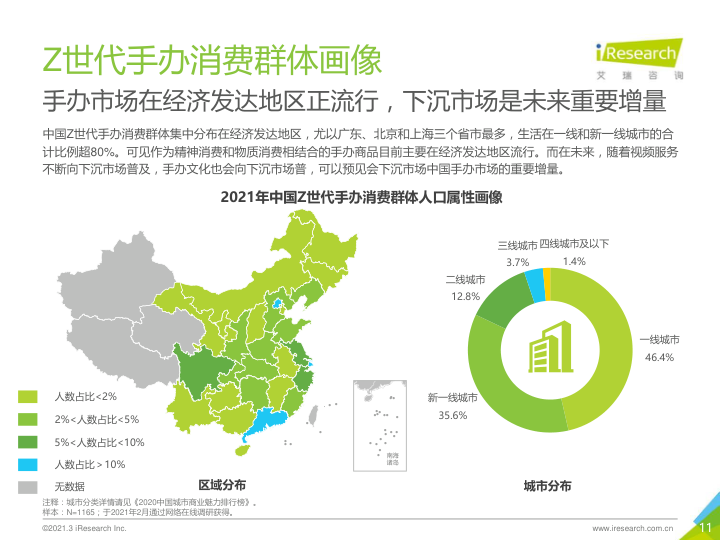

In [11]:
from IPython.display import Image as IPImage
from IPython.display import display

file_path = "../../sources/2021年中国Z世代手办消费趋势研究报告.pdf"

# 以base64展示
base64_image = pdf_page_to_base64(file_path, 11)
display(IPImage(data=base64.b64decode(base64_image)))

In [12]:
# 使用多模态模型
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model=os.environ.get("OPENAPI_MODEL"),
    base_url=os.environ.get("OPENAPI_API_BASE"),
    api_key=os.environ.get("OPENAPI_API_KEY"),
    temperature=0,
)


In [14]:
from langchain_core.messages import HumanMessage

query = "一线城市消费者占比有多少？"

message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{base64_image}"},
        },
    ]
)

response = llm.invoke([message])
print(response.content)

BadRequestError: Error code: 400 - {'error': {'code': 'InvalidParameter', 'message': 'One or more parameters specified in the request are not valid. Request id: 021758088652721887e6a1b6e8a1bc592f8c3c879109657abef5e', 'param': '', 'type': 'BadRequest'}}

## 解析网页

In [15]:
! pip install -qU langchain-community beautifulsoup4 unstructured

In [16]:
! pip install -qU langchain-unstructured

In [ ]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

page_url = "https://python.langchain.com/docs/how_to/chatbots_memory/"

# 加载网页
loader = WebBaseLoader(web_paths=[page_url])
docs = []
async for doc in loader.alazy_load():
    docs.append(doc)

assert len(docs) == 1
doc = docs[0]

USER_AGENT environment variable not set, consider setting it to identify your requests.
Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.64it/s]


In [18]:
print(f"{doc.metadata}\n")
print(doc.page_content[:500].strip())

{'source': 'https://python.langchain.com/docs/how_to/chatbots_memory/', 'title': 'How to add memory to chatbots | 🦜️🔗 LangChain', 'description': 'A key feature of chatbots is their ability to use the content of previous conversational turns as context. This state management can take several forms, including:', 'language': 'en'}

How to add memory to chatbots | 🦜️🔗 LangChain








Skip to main contentThese docs will be deprecated and no longer maintained with the release of LangChain v1.0 in October 2025. Visit the v1.0 alpha docsIntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templates


### 制定加载网页某一部分

In [19]:
loader = WebBaseLoader(
    web_paths=[page_url],
    bs_kwargs={
        "parse_only": bs4.SoupStrainer(class_="theme-doc-markdown markdown"),
    },
    bs_get_text_kwargs={"separator": " | ", "strip": True},
)

docs = []
async for doc in loader.alazy_load():
    docs.append(doc)

assert len(docs) == 1
doc = docs[0]


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.66it/s]


In [20]:
print(f"{doc.metadata}\n")
print(doc.page_content[:500].strip())

{'source': 'https://python.langchain.com/docs/how_to/chatbots_memory/'}

How to add memory to chatbots | A key feature of chatbots is their ability to use the content of previous conversational turns as context. This state management can take several forms, including: | Simply stuffing previous messages into a chat model prompt. | The above, but trimming old messages to reduce the amount of distracting information the model has to deal with. | More complex modifications like synthesizing summaries for long running conversations. | We'll go into more detail on a few t


### 高级：对于网页结构不熟悉的情况下解析网页

In [24]:
from langchain_unstructured import UnstructuredLoader
import nltk

nltk.download("punkt_tab")

page_url = "https://python.langchain.com/docs/how_to/chatbots_memory/"
loader = UnstructuredLoader(web_url=page_url)

docs = []
async for doc in loader.alazy_load():
    docs.append(doc)

[nltk_data] Downloading package punkt_tab to /home/jizhe/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [25]:
for doc in docs[:5]:
    print(doc.page_content)

Open In Colab
Open on GitHub
How to add memory to chatbots
A key feature of chatbots is their ability to use the content of previous conversational turns as context. This state management can take several forms, including:
Simply stuffing previous messages into a chat model prompt.


## 加载CVS

In [27]:
from langchain_community.document_loaders.csv_loader import CSVLoader

file_path = "../../sources/loader.csv"

loader = CSVLoader(file_path=file_path)
data = loader.load()

for record in data[:2]:
    print(record)

page_content='﻿Project: AI GC培训
DES: 培训课程
Price: 500
People: 100
Location: 北京' metadata={'source': '../../sources/loader.csv', 'row': 0}
page_content='﻿Project: AI工程师认证
DES: 微软AI认证
Price: 6000
People: 200
Location: 西安' metadata={'source': '../../sources/loader.csv', 'row': 1}


### 指定一列加载CSV

In [33]:
loader = CSVLoader(file_path=file_path, source_column="People")

data = loader.load()
for record in data[:2]:
    print(record)

page_content='﻿Project: AI GC培训
DES: 培训课程
Price: 500
People: 100
Location: 北京' metadata={'source': '100', 'row': 0}
page_content='﻿Project: AI工程师认证
DES: 微软AI认证
Price: 6000
People: 200
Location: 西安' metadata={'source': '200', 'row': 1}


## 解析Excel
使用微软云的Document intelligence服务来解析，需要申KEY

In [34]:
! pip install azure-ai-documentintelligence

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [azure-ai-documentintelligence]umentintelligence]


In [36]:
from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader

file_path = "../../sources/fake.xlsx"
endpoint = "https://jiaoxue.cognitiveservices.azure.com/"
key = "FdSAWGHWSQhEKKEYUN10aBVR4a5f8GXJGPMPMYTAM70LABS10GSHJ00J99BCAC8VTInXJ3W3AAALACOGTOVM"
loader = AzureAIDocumentIntelligenceLoader(
    api_endpoint=endpoint, api_key=key, file_path=file_path, api_model="prebuilt-layout"
)
documents = loader.load()

INFO: Request URL: 'https://jiaoxue.cognitiveservices.azure.com//documentintelligence/documentModels/prebuilt-layout:analyze?api-version=REDACTED&outputContentFormat=REDACTED'
Request method: 'POST'
Request headers:
    'content-type': 'application/octet-stream'
    'Accept': 'application/json'
    'x-ms-client-request-id': '5bfde696-938f-11f0-b110-00155d843037'
    'x-ms-useragent': 'REDACTED'
    'User-Agent': 'azsdk-python-ai-documentintelligence/1.0.2 Python/3.12.11 (Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.39)'
    'Ocp-Apim-Subscription-Key': 'REDACTED'
A body is sent with the request


ServiceResponseError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

## 自定义文档加载器

一个文档加载器包含的主要方法
+ lazy_load
+ alazy_load
+ load
+ aload

In [37]:
! pip install aiofiles

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [38]:
from typing import AsyncIterator, Iterator

from langchain_core.document_loaders import BaseLoader
from langchain_core.documents import Document


class CustomDocumentLoader(BaseLoader):
    """自定义文档加载器"""

    def __init__(self, file_path: str):
        """使用文档路径初始化加载器

        参数：
            file_path: 要加载的文件路径
        """
        self.file_path = file_path

    def lazy_load(self) -> Iterator[Document]:
        """逐行读取文件的惰性加载器

        当实现惰性加载方式时，应该使用生成器
        一次生成一个文档
        """
        with open(self.file_path, encoding="utf-8") as f:
            line_number = 0
            for line in f:
                yield Document(
                    page_content=line,
                    metadata={"line_number": line_number, "source": self.file_path},
                )
                line_number += 1

    async def alazy_load(self) -> AsyncIterator[Document]:
        """alazy_load 时可选的
        如果不实现它，将使用一个默认实现，该实现会委托给lazy_load
        逐行读取文件的异步惰性加载器
        """
        import aiofiles

        async with aiofiles.open(self.file_path, encoding="utf-8") as f:
            line_number = 0
            async for line in f:
                yield Document(
                    page_content=line,
                    metadata={"line_number": line_number, "source": self.file_path},
                )
                line_number += 1

    def load(self) -> list[Document]:
        """Load the data in the document."""
        return [Document(page_content="This is a loaded document")]

    async def aload(self) -> list[Document]:
        """Load the data in the document."""
        return [Document(page_content="This is an async loaded document")]

### 测试

In [ ]:
file_path = "meow.txt"

with open(file_path, "w", encoding="utf-8") as f:
    quality_content = "meow meow🐱 \n meow meow🐱 \n meow meow🐱 \n"
    f.write(quality_content)

loader = CustomDocumentLoader(file_path)

# 测试懒加载
for doc in loader.lazy_load():
    print()
    print(type(doc))
    print(doc)


<class 'langchain_core.documents.base.Document'>
page_content='meow meow🐱 
' metadata={'line_number': 0, 'source': 'meow.txt'}

<class 'langchain_core.documents.base.Document'>
page_content=' meow meow🐱 
' metadata={'line_number': 1, 'source': 'meow.txt'}

<class 'langchain_core.documents.base.Document'>
page_content=' meow meow🐱 
' metadata={'line_number': 2, 'source': 'meow.txt'}
